<a href="https://colab.research.google.com/github/meanwo/meanwo/blob/master/ex_0205_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 시계열 예측:

In [1]:
import numpy as np
import pandas as pd
import io
import warnings 
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab.files import upload                                       # Colab으로 file올려주기 위한 함수.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.filterwarnings('ignore')                  # Turn the warnings off.
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. 머신러닝 방법으로 예측:

#### 1.1. 데이터를 읽어와서 탐색한다: 

In [2]:
# Colab에 데이터를 올려준다.
dict_data = upload()                     # 실행하고 data_time_series.csv를 찾아서 올려준다.
df = pd.read_csv(io.BytesIO(dict_data['data_time_series.csv']))   
# 아니면 다음과 같이 로컬 데이터를 사용한다.
#df = pd.read_csv('..\data\data_time_series.csv', header='infer',encoding = 'latin1')
n_time_steps = df.shape[0]
print(df.shape)

Saving data_time_series.csv to data_time_series.csv
(41, 1)


In [3]:
# DataFrame 출력.
df.head()

,Value
0,2.26483
1,3.80588
2,4.21088
3,3.48790
4,4.86365


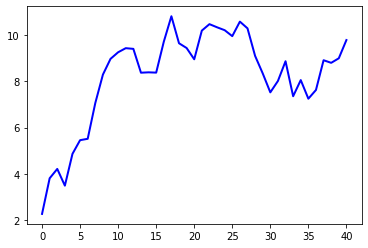

In [4]:
# 시계열 시각화.
plt.plot(df.Value, c="b", linewidth=2, linestyle="-")
plt.show()

#### 1.2. 지수 평활화 방법을 적용한 예측: 

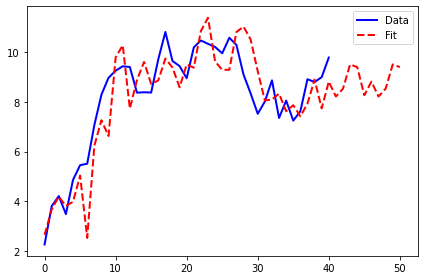

In [5]:
model = ExponentialSmoothing(df['Value'][0:40], seasonal='mul',seasonal_periods=6).fit()    # "승법 모델" 적용.
pred = model.predict(start= 0, end=50)                                                        
plt.plot(df,c='b',linewidth=2, linestyle="-", label="Data")
plt.plot(pred,c='r',linewidth=2, linestyle="--", label="Fit")
plt.legend()
plt.tight_layout()
plt.show()

### 2. 딥러닝 (RNN, LSTM) 방법으로 예측:

#### 2.1. 데이터 전처리:

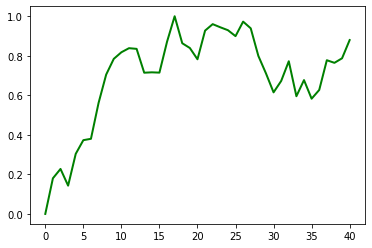

In [6]:
# Scaling.
# 아래 그래프에서 세로축의 scale에 주목!
my_scaler = MinMaxScaler()
ts_scaled = my_scaler.fit_transform(df)
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [7]:
# Reshaping.
ts_scaled_2 = ts_scaled.reshape(1,-1,1)             # (batch_size, time series length, n_input)

#### 2.2. 딥러닝 모델 정의:

Hyperparameters.

In [8]:
n_epochs = 4000                   
batch_size = 1                    # 데이터로 주어진 시계열은 단 한 개. 그러므로 batch_size = 1 이외의 선택은 없다.  
learn_rate = 0.0001       

In [9]:
n_input = 1                       # Scalar 값 입력.
n_hidden = 100                   # 층 별 neuron의 수.
n_output = 1                      # Scalar 값 출력.

Sequence to Sequence Model.

In [10]:
# RNN 또는 LSTM network.
# return_sequences = True: "Sequence to Sequence" 모델을 의미한다.
# input_shape = (None, n_input) :  "None"은 가변적인 시계열 길이를 나타낸다.
my_model = Sequential()
my_model.add(SimpleRNN(units=n_hidden,return_sequences=True, input_shape=(None, n_input), activation="relu"))     # RNN.
#my_model.add(LSTM(units=n_hidden,return_sequences=True, input_shape=(None, n_input),activation="relu"))         # LSTM.
my_model.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

In [11]:
# 모델의 summary (내부 구조) 출력.
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 100)         10200     
                                                                 
 time_distributed (TimeDistr  (None, None, 1)          101       
 ibuted)                                                         
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Optimizer 객체 생성 후 컴파일한다.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

#### 2.3. 학습 진행:

In [13]:
# No validation.
# 주의: y 는 X를 +1 shifting 한 것이다!!!
my_EarlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)          # 조기 종료 허락!
my_summary = my_model.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 1, callbacks=[my_EarlyStop])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 20ms/step - loss: 3.8253e-04 - mse: 3.8253e-04
Epoch 2335/4000
1/1 [==============================] - 0s 23ms/step - loss: 3.8050e-04 - mse: 3.8050e-04
Epoch 2336/4000
1/1 [==============================] - 0s 19ms/step - loss: 3.8142e-04 - mse: 3.8142e-04
Epoch 2337/4000
1/1 [==============================] - 0s 24ms/step - loss: 3.8148e-04 - mse: 3.8148e-04
Epoch 2338/4000
1/1 [==============================] - 0s 26ms/step - loss: 3.7863e-04 - mse: 3.7863e-04
Epoch 2339/4000
1/1 [==============================] - 0s 49ms/step - loss: 3.7799e-04 - mse: 3.7799e-04
Epoch 2340/4000
1/1 [==============================] - 0s 53ms/step - loss: 3.7886e-04 - mse: 3.7886e-04
Epoch 2341/4000
1/1 [==============================] - 0s 39ms/step - loss: 3.7695e-04 - mse: 3.7695e-04
Epoch 2342/4000
1/1 [==============================] - 0s 44ms/step - loss: 3.7534e-04 - mse: 3.7534e-04
Epoch 2343/4000
1/1 [==============

In [14]:
my_summary.history.keys()

dict_keys(['loss', 'mse'])

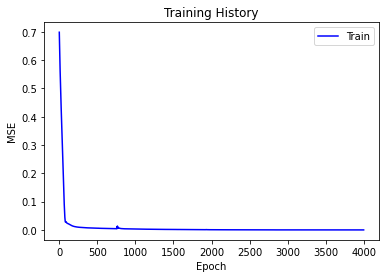

In [15]:
# 학습 history 출력. 
plt.plot(my_summary.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

#### 2.4. 예측:

In [16]:
n_ts_seed = 5                                 # Seed 길이.
n_predict_time_steps = 55                     # 예측할 길이.

In [17]:
# 예측 루프.
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model.predict(X)
    y_last= y_pred[0,-1,0]             # 마지막 출력이 바로 y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(-1,1)), axis=0)

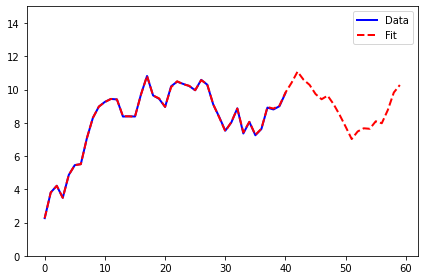

In [18]:
# 역변환을 하고 시계열을 출력한다.. 
ts = my_scaler.inverse_transform(ts_seed)
plt.plot(df.Value,c='b',linewidth=2, linestyle="-",label="Data")
plt.plot(ts,c='r',linewidth=2, linestyle="--",label="Fit")
plt.legend()
plt.ylim([0,15])
plt.tight_layout()
plt.savefig("out.png")
plt.show()